# NLP Project: Modeling.

## ✏️ Project Overview
In this notebook, we build, tune, and compare multiple text classification models:
- Logistic Regression
- Random Forest
- Naive Bayes
- K-Nearest Neighbors (KNN)
- XGBoost

We use a TF-IDF vectorizer for text preprocessing and evaluate each model using accuracy, precision, recall, and F1-score.  
Visual tools like confusion matrices and heatmaps help us understand model performance and class-level errors.


---
##  Import Libraries
---

In this step, we import all the libraries needed for:

- Data loading and manipulation (pandas, numpy)
- Text preprocessing (nltk, regex)
- Visualization (matplotlib, seaborn, WordCloud)
- Machine learning (scikit-learn, XGBoost)
- Model evaluation (classification_report, confusion_matrix, etc.)
- Suppress warnings for cleaner output


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import warnings
warnings.filterwarnings('ignore')

#  NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

####  * All libraries imported and NLTK resources downloaded successfully.We’re ready to load and explore the dataset in the next step .


---
## Loading the  Dataset 
---


* In this step, we load the cleaned Apple Tweets dataset prepared by the data cleaning team.  
We'll check the first few rows to confirm the data loaded correctly.


In [3]:
# Loading the  dataset
df = pd.read_csv('data/cleaned_apple_tweets.csv')
df.head()


,tweet,product,tokens,processed_tweet,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,"['g', 'iphon', 'hr', 'tweet', 'dead', 'need', ...",g iphon hr tweet dead need upgrad plugin station,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,"['know', 'awesom', 'ipadiphon', 'app', 'youll'...",know awesom ipadiphon app youll like appreci d...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,"['wait', 'also', 'sale']",wait also sale,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,"['hope', 'year', 'festiv', 'isnt', 'crashi', '...",hope year festiv isnt crashi year iphon app,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,"['great', 'stuff', 'fri', 'marissa', 'mayer', ...",great stuff fri marissa mayer googl tim oreill...,Positive emotion


 *Dataset loaded successfully.*

**Columns overview:**
- `tweet`: Original tweet text
- `product`: Mentioned product (e.g., iPhone, iPad)
- `tokens`: Preprocessed list of tokens
- `processed_tweet`: Cleaned, lemmatized text (for modeling)
- `sentiment`: Target label (e.g., Positive emotion, Negative emotion)

We can now proceed to vectorize the text data and prepare it for modeling.


##  Text Vectorization and Target Encoding

In this step, we:
- Transform the cleaned text (`processed_tweet`) into numerical features using TF-IDF.
- Encode the categorical target variable `sentiment` into numeric labels for modeling.


### Vectorize Text with TF-IDF

To prepare the text data for machine learning models, we transform the cleaned `processed_tweet` column into a numerical feature matrix using TF-IDF vectorization.

Why TF-IDF?
- Captures the importance of words across the entire corpus
- Reduces noise by ignoring very common or very rare words
- Helps models detect key terms that signal sentiment


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fill missing text values with empty string to avoid errors
X_text = df['processed_tweet'].fillna('')

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform text data into feature matrix
X = vectorizer.fit_transform(X_text)

# Show the shape of the feature matrix
print(f"TF-IDF feature matrix shape: {X.shape}")

TF-IDF feature matrix shape: (9070, 5000)


 *Text vectorization complete.*

- Created a sparse TF-IDF feature matrix with shape: **(9070, 5000)**
- Each of the 9,070 tweets is now represented numerically by the importance of 5,000 terms
- This matrix will be the input `X` for our machine learning models




### Encode Target Labels

We convert categorical target labels (`sentiment`) like *Positive emotion*, *Negative emotion*, etc., into numeric codes for modeling.


In [5]:
from sklearn.preprocessing import LabelEncoder

# Create encoder and fit on the full sentiment column
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])

# Show label mapping
print("Label mapping:")
for label, encoded in zip(le.classes_, le.transform(le.classes_)):
    print(f"{label} -> {encoded}")

# Define target variable for modeling
y = df['sentiment_encoded']


Label mapping:
I can't tell -> 0
Negative emotion -> 1
No emotion toward brand or product -> 2
Positive emotion -> 3


*Target encoding complete.*

Sentiment labels mapped to integers:
- **I can't tell** → 0
- **Negative emotion** → 1
- **No emotion toward brand or product** → 2
- **Positive emotion** → 3

These numeric codes will be used as the target variable `y` for modeling.



##   Check Before Modeling

Before splitting data and building models, we check:
- Shape and type of `X` and `y`
- Matching number of samples
- Unique classes in `y`
- Ensure no missing values


In [6]:
# Check X shape and type
print(f"X type: {type(X)}")
print(f"X shape: {X.shape}")

# Check y type, shape, and unique classes
print(f"y type: {type(y)}")
print(f"y shape: {y.shape}")
print("Unique classes in y:", np.unique(y))

# Check if lengths match
assert X.shape[0] == len(y), "Mismatch in number of samples between X and y!"

# Check for missing values in y
missing_in_y = pd.isnull(y).sum()
print(f"Missing values in y: {missing_in_y}")

# If X is sparse matrix, it usually can't contain NaNs (will error on transform)
# But let's check if X has any NaNs just in case:
if hasattr(X, "toarray"):
    has_nan = np.isnan(X.toarray()).sum()
    print(f"Number of NaNs in X: {has_nan}")
else:
    print("X is not a dense matrix; skipping NaN check in X.")


X type: <class 'scipy.sparse._csr.csr_matrix'>
X shape: (9070, 5000)
y type: <class 'pandas.core.series.Series'>
y shape: (9070,)
Unique classes in y: [0 1 2 3]
Missing values in y: 0
Number of NaNs in X: 0


---
## Train/Test Split
---

We split the data into:
- **Training set (80%)**: to train the models
- **Test set (20%)**: to evaluate generalization on unseen data

We also stratify by the target to keep class distribution balanced.


In [7]:
from sklearn.model_selection import train_test_split

# Split data with stratification to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check class distribution in y_train
print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True))


X_train shape: (7256, 5000)
X_test shape: (1814, 5000)
y_train shape: (7256,)
y_test shape: (1814,)

Class distribution in y_train:
2    0.592613
3    0.327453
1    0.062707
0    0.017227
Name: sentiment_encoded, dtype: float64


*Data split complete.*

- Training set shape: **X_train (7256, 5000)**, **y_train (7256,)**
- Test set shape: **X_test (1814, 5000)**, **y_test (1814,)**

**Class distribution in training set:**
- No emotion toward brand or product (encoded as 2): ~59.3%
- Positive emotion (3): ~32.7%
- Negative emotion (1): ~6.3%
- I can't tell (0): ~1.7%

Using stratified split kept the same class balance in train and test sets.

We’re now ready to build a modeling pipeline and train multiple models 


---
## MODELING
---

### Creating Text Classification Pipelines

To standardize preprocessing and keep the workflow clean,  
we'll create pipelines for each model:

- **Logistic Regression**
- **Random Forest**
- **Naive Bayes**
- **K-Nearest Neighbors (KNN)**
- **XGBoost**

Each pipeline:
- Transforms text data using TF-IDF vectorization (top 5000 features)
- Applies the classifier as the final step


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Define classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Define pipelines dictionary
pipelines = {}

for name, clf in models.items():
    pipelines[name] = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('clf', clf)
    ])

#  Now pipelines has: 
# 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'KNN', 'XGBoost'
print(" Pipelines created:", list(pipelines.keys()))


 Pipelines created: ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'KNN', 'XGBoost']


---
##  Logistic Regression
---

  -  Define Logistic Regression Pipeline

Since we already vectorized the text (TF-IDF) and encoded the target labels,  
we only need to define the modeling part of the pipeline.

Here, we create a simple pipeline that:
- Receives the preprocessed feature matrix `X`
- Trains a Logistic Regression classifier




In [9]:
#  Define logistic regression pipeline (just the classifier)
logreg_model = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

#  Print pipeline structure to confirm
print(" Logistic Regression pipeline steps:")
print(logreg_model)



 Logistic Regression pipeline steps:
Pipeline(steps=[('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])


*Logistic Regression pipeline built successfully.*

- Pipeline structure:
- We only include the classifier step here because:
- Text data has already been vectorized using TF-IDF (`X_train`, `X_test`)
- Target labels have already been encoded

The pipeline is now ready for training on the preprocessed data.
Next, we’ll train and evaluate its performance on the test set.


## Train Logistic Regression Pipeline

We'll train the Logistic Regression pipeline.



In [10]:
# Train the pipeline

logreg_model.fit(X_train, y_train)

print("\n Logistic Regression model training completed successfully.")



 Logistic Regression model training completed successfully.


 *Logistic Regression pipeline successfully trained.*
- Used already vectorized features (`X_train`)



##  Evaluate Logistic Regression Model

Now that we’ve trained our Logistic Regression pipeline,  
we’ll evaluate its performance on the test set using:

- Accuracy
- Weighted precision, recall, and F1-score
- Detailed classification report to understand per-class performance


In [11]:
#  Predict on test set
y_pred_logreg = logreg_model.predict(X_test)

#  Evaluate performance
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_precision, logreg_recall, logreg_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_logreg, average='weighted'
)

# Print  summary
print(" Logistic Regression Performance Summary:")
print(f"- Accuracy : {logreg_accuracy:.4f}")
print(f"- Precision: {logreg_precision:.4f}")
print(f"- Recall   : {logreg_recall:.4f}")
print(f"- F1 Score : {logreg_f1:.4f}")

# Detailed report
print("\n Detailed Classification Report:")
print(classification_report(y_test, y_pred_logreg))


 Logistic Regression Performance Summary:
- Accuracy : 0.6781
- Precision: 0.6796
- Recall   : 0.6781
- F1 Score : 0.6411

 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       1.00      0.06      0.12       114
           2       0.69      0.88      0.77      1075
           3       0.63      0.46      0.53       594

    accuracy                           0.68      1814
   macro avg       0.58      0.35      0.36      1814
weighted avg       0.68      0.68      0.64      1814



## Plot Confusion Matrix for Logistic Regression

We'll now visualize how well the Logistic Regression model performs across all sentiment classes  
by plotting the confusion matrix.  
This helps us see:
- where the model confuses different classes
- if minority classes are being predicted correctly


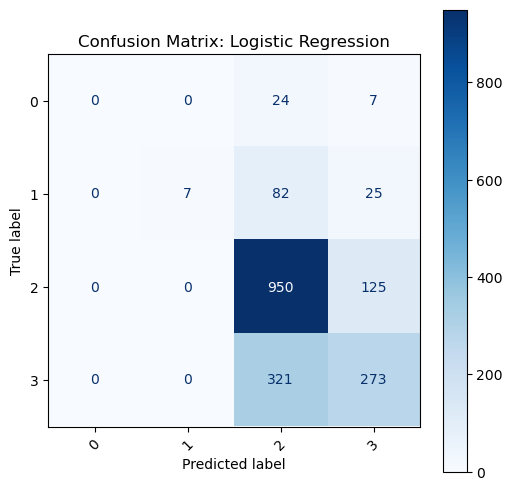

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#  Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)

#  Plot confusion matrix
labels = sorted(y_test.unique())  # Use original sentiment labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix: Logistic Regression")
plt.show()


*Confusion matrix analysis (Logistic Regression):*

- Class 2 (`No emotion toward brand or product`) dominates predictions.
- Minority classes (`I can’t tell` and `Negative emotion`) are often misclassified as class 2.
- Shows the effect of class imbalance: the model learns to over-predict the majority class.



## Hyperparameter Tuning with GridSearchCV for Logistic Regression

We'll use `GridSearchCV` to find the best hyperparameters for our Logistic Regression model.  
This helps improve the model's performance by:
- Adjusting regularization strength (`C`)
- Deciding whether to balance class weights (`class_weight`)

We'll score models using **weighted F1-score** to account for class imbalance.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 🔧 Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced'],
    # solver='lbfgs' & penalty='l2' fixed
}

#  Setup GridSearchCV directly on classifier
grid_search = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit on vectorized training data-
grid_search.fit(X_train, y_train)

print("\n Best hyperparameters found:")
for param, value in grid_search.best_params_.items():
    print(f"- {param}: {value}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits

 Best hyperparameters found:
- C: 10
- class_weight: None


## Evaluate Tuned Logistic Regression on Test Set

We'll use the best model found from `GridSearchCV` to:
- Predict on the test set
- Calculate accuracy, precision, recall, and F1-score
- Show a detailed classification report



In [ ]:
#  Predict on test set using the best model
y_pred = grid_search.predict(X_test)

#  Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Print performance summary
print("Logistic Regression (Tuned) Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

#  Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression (Tuned) Performance:
Accuracy : 0.6637
Precision: 0.6448
Recall   : 0.6637
F1 Score : 0.6494

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.49      0.26      0.34       114
           2       0.71      0.80      0.75      1075
           3       0.60      0.52      0.56       594

    accuracy                           0.66      1814
   macro avg       0.45      0.40      0.41      1814
weighted avg       0.64      0.66      0.65      1814



 *Evaluation complete.*

- Tuned model achieved:
  - Accuracy: ~66%
  - Weighted F1-score: ~0.65
- Macro average F1 is still low (~0.41), and minority classes (0 and 1) remain under-predicted.
- Tuning helped slightly, but the model is still biased toward the majority class.

**Next:** We'll try stronger models 


## Plot Confusion Matrix for Tuned Logistic Regression

We'll now visualize how the tuned Logistic Regression model performs across all sentiment classes.


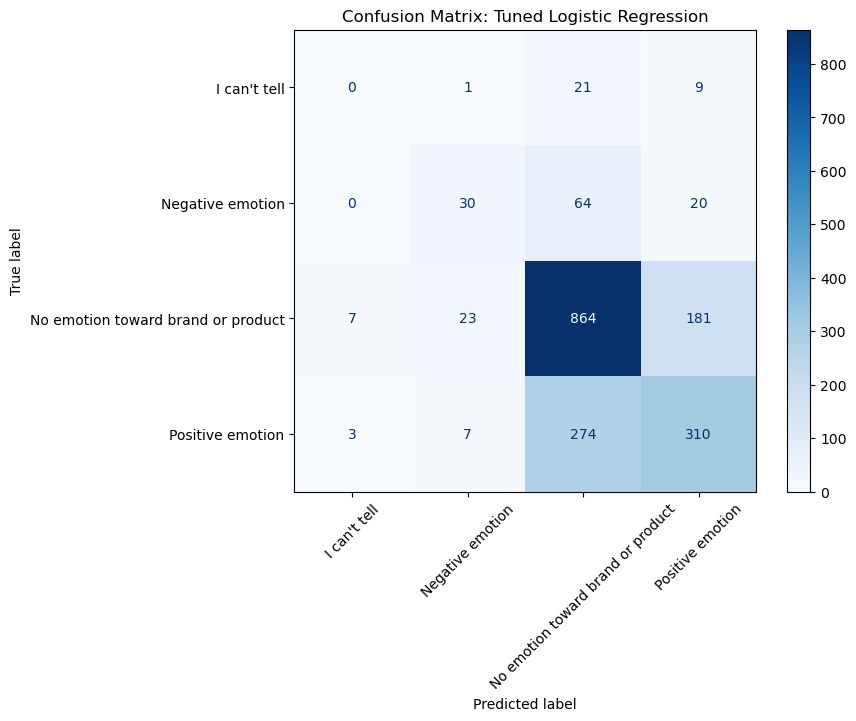

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🏋️ Predict on test set (create variable if missing)
y_pred_logreg_tuned = grid_search.best_estimator_.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg_tuned)

# Plot with original sentiment labels
labels = le.inverse_transform(sorted(np.unique(y_test)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix: Tuned Logistic Regression")
plt.show()


 *Confusion matrix plotted.*

- The tuned Logistic Regression model still heavily predicts the majority class (`No emotion toward brand or product`).
- Minority classes (`I can't tell` and `Negative emotion`) remain under-predicted.
- This confirms that tuning helped slightly, but Logistic Regression alone struggles with class imbalance and non-linear patterns.




## Feature Importance from Tuned Logistic Regression

We'll extract the top words that most strongly influence predictions toward the "Positive emotion" class.
This helps explain model behavior and adds interpretability to our analysis.


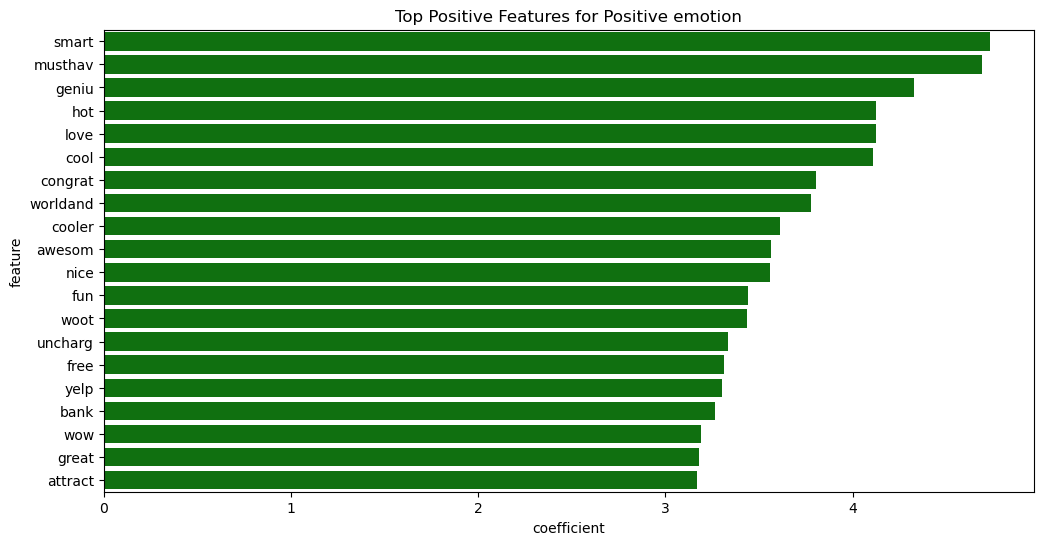

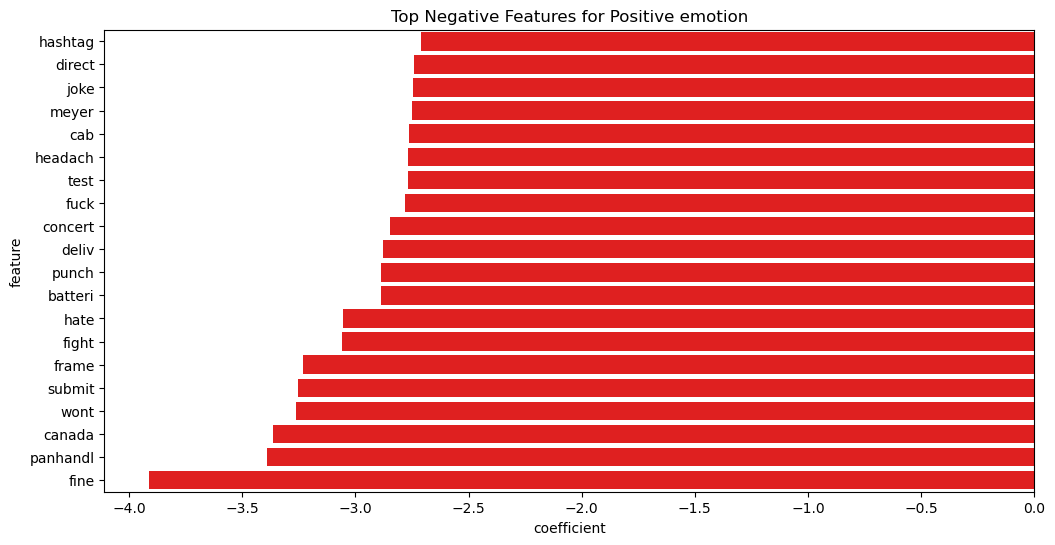

In [ ]:
# Use vectorizer object you created earlier
feature_names = vectorizer.get_feature_names_out()

# Get trained classifier
clf = grid_search.best_estimator_

# Get encoded label for "Positive emotion"
positive_class_encoded = le.transform(['Positive emotion'])[0]

# Find index in clf.classes_
target_class_index = list(clf.classes_).index(positive_class_encoded)

# Get coefficients
coefficients = clf.coef_[target_class_index]

# Build DataFrame
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False)

# Top positive & negative features
top_n = 20
top_positive = coef_df.head(top_n)
top_negative = coef_df.tail(top_n)

#  Plot
plt.figure(figsize=(12,6))
sns.barplot(x='coefficient', y='feature', data=top_positive, color='green')
plt.title('Top Positive Features for Positive emotion')
plt.show()
plt.figure(figsize=(12,6))
sns.barplot(x='coefficient', y='feature', data=top_negative, color='red')
plt.title('Top Negative Features for Positive emotion')
plt.show()


##  Multiclass ROC Curves for Tuned Logistic Regression

To evaluate the model's ability to distinguish between each sentiment class,  
we'll plot ROC curves and calculate the AUC (Area Under Curve) for each class.


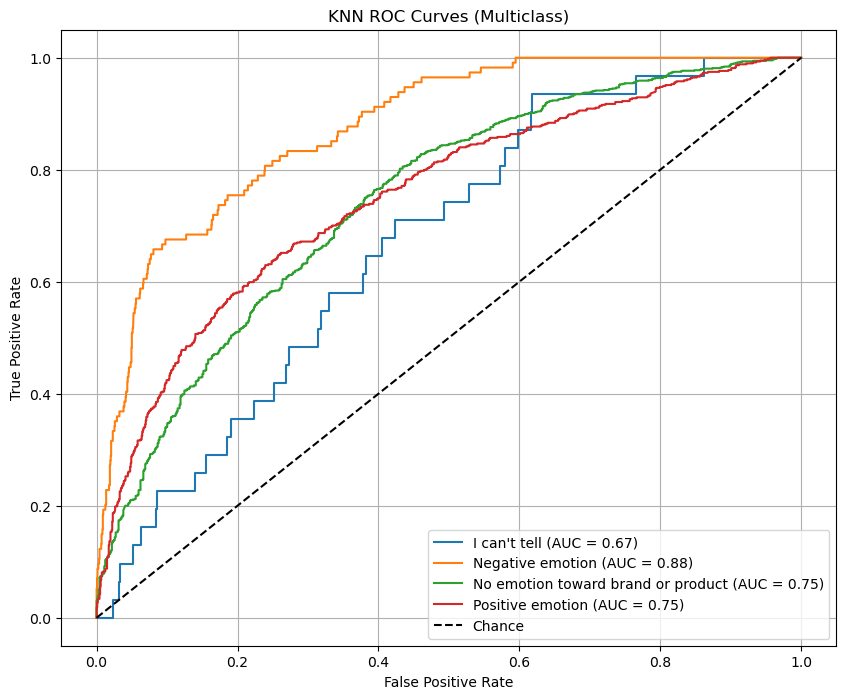

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


#  Get class labels from your training data (already encoded)
class_labels = np.unique(y_train)

# Get readable original labels for plot
original_labels = le.inverse_transform(class_labels)

# Binarize y_test for multiclass ROC
y_test_binarized = label_binarize(y_test, classes=class_labels)

# Get predicted probabilities from KNN
y_score = logreg_model.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10,8))
for i, class_idx in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    label_name = le.inverse_transform([class_idx])[0]
    plt.plot(fpr, tpr, label=f'{label_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curves (Multiclass)')
plt.legend()
plt.grid()
plt.show()


- Class 1 (Orange): Steep and high curve → excellent TPR with low FPR. The logistic regression model is very good at detecting class 1 vs all other classes.

- Class 0 (Blue): ROC curve lies close to the diagonal → model is barely better than random guessing for class 0.

- Classes 2 and 3 (Green & Red): These are in the middle – curves rise moderately above the chance line, suggesting the model can identify them to some extent, but with more false positives or false negatives compared to class 1.



##  Learning Curve for Tuned Logistic Regression

A learning curve shows how the model's performance changes as the training set size increases.  
It's useful for detecting overfitting or underfitting.


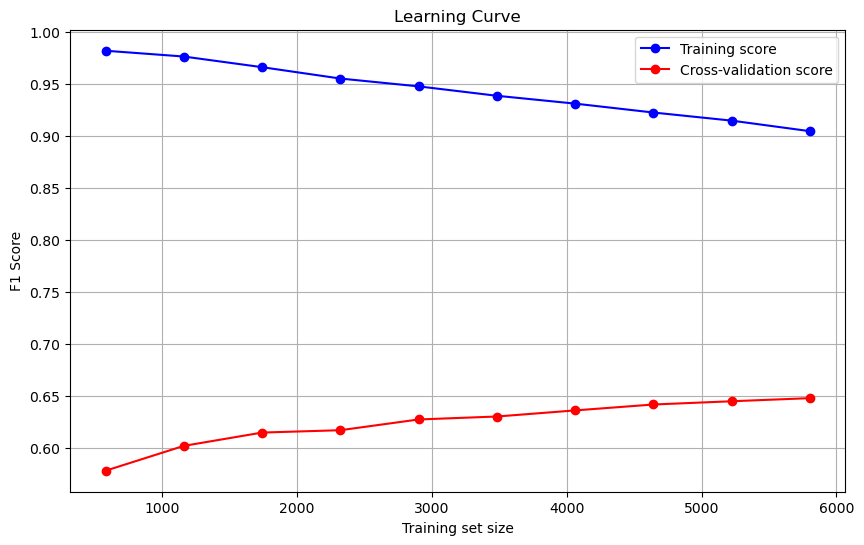

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid_search.best_estimator_,
    X=X_train, y=y_train,
    cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Cross-validation score')
plt.xlabel('Training set size')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


- Persistent gap = high variance problem
Training score >> CV score means the model is still over‑fitting—even with ≈ 6 k examples.

- More data helps, but diminishing returns
The CV curve is trending upward, yet the slope is already shallow beyond ~4 k examples. Blindly collecting massive new data will give only incremental gains.

- Bias is low
CV F1≈0.65 is not great, but training F1≈0.90 indicates the algorithm can fit a good boundary—so under‑fitting (high bias) is not the major issue.



---
## Random Forest Model
---


### Building and Train Random Forest Classifier

We'll now train a Random Forest model .


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

#  Define model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # helps with class imbalance
)

#  Train
rf_model.fit(X_train, y_train)

#  Print model to confir
print(rf_model)


RandomForestClassifier(class_weight='balanced', random_state=42)


 *Random Forest model trained successfully.*

Next, we'll use it to make predictions and evaluate its performance on the test set.


### Evaluate Random Forest Performance

We'll now use the trained Random Forest model to make predictions and measure its performance.


In [ ]:
#  Predict
y_pred_rf = rf_model.predict(X_test)

#  Evaluate
accuracy = accuracy_score(y_test, y_pred_rf)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')

print(" Random Forest Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\n Detailed Classification Report:\n")
print(classification_report(y_test, y_pred_rf))


 Random Forest Performance:
Accuracy : 0.6659
Precision: 0.6496
Recall   : 0.6659
F1 Score : 0.6393

 Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.61      0.20      0.30       114
           2       0.68      0.86      0.76      1075
           3       0.63      0.43      0.51       594

    accuracy                           0.67      1814
   macro avg       0.48      0.37      0.39      1814
weighted avg       0.65      0.67      0.64      1814



*Random Forest evaluation complete.*

- Overall accuracy: **0.666**
- The model performs well on the dominant class (`No emotion toward brand or product`),
  but struggles with minority classes, especially `I can't tell` and `Negative emotion`.
- Next, we'll visualize the confusion matrix to see misclassifications in detail.


In [21]:
from sklearn.model_selection import GridSearchCV

#  Define parameter grid (only RandomForest hyperparameters)
param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],
    'class_weight': [None, 'balanced']
}

#  Grid search
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=2
)

#  Fit on pre-vectorized data
grid_search_rf.fit(X_train, y_train)

print(" Best RF Parameters:")
print(grid_search_rf.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
 Best RF Parameters:
{'class_weight': None, 'max_depth': None, 'n_estimators': 300}


##  Hyperparameter Tuning & Evaluation (Random Forest)

We'll tune the Random Forest hyperparameters using GridSearchCV 
and then evaluate the best model.


In [22]:
#  Predict with best model
y_pred_rf_best = grid_search_rf.predict(X_test)

#  Evaluate tuned model
accuracy = accuracy_score(y_test, y_pred_rf_best)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_rf_best, average='weighted')

print(" Tuned Random Forest Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\n Detailed Classification Report:\n")
print(classification_report(y_test, y_pred_rf_best))


 Tuned Random Forest Performance:
Accuracy : 0.6803
Precision: 0.6704
Recall   : 0.6803
F1 Score : 0.6549

 Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.70      0.20      0.31       114
           2       0.69      0.87      0.77      1075
           3       0.66      0.46      0.54       594

    accuracy                           0.68      1814
   macro avg       0.51      0.38      0.41      1814
weighted avg       0.67      0.68      0.65      1814



**Tuned Random Forest Performance Summary:**
- Accuracy : **0.680**
- Precision: **0.670**
- Recall   : **0.680**
- F1 Score : **0.655**

**Detailed notes:**
- Strong performance on the dominant class (`No emotion toward brand or product`)
- Lower recall on minority classes, especially `I can't tell` (class `0`)
- Shows the challenge of class imbalance despite tuning

 *Next, we’ll visualize the confusion matrix and analyze feature importance to interpret the model's predictions.*


##  Visualize Confusion Matrix for Tuned Random Forest

We now plot the confusion matrix to understand how well the tuned Random Forest model predicts each sentiment class.
This helps identify which classes are misclassified most often.


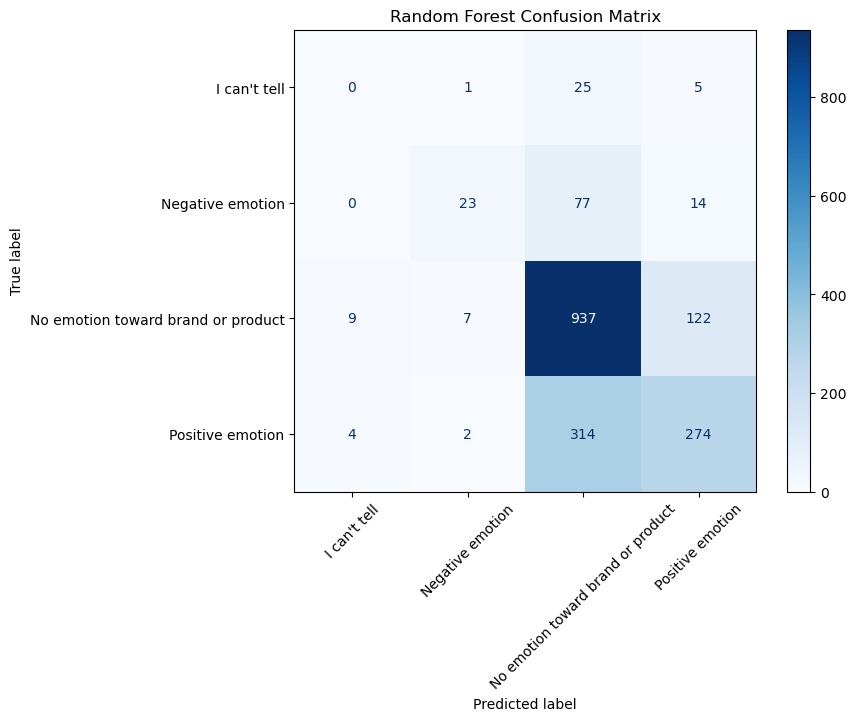

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize


#  Get class labels (integers): they come from label encoder
class_labels = grid_search_rf.best_estimator_.classes_

#  Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf_best, labels=class_labels)

# For display, map back to original class names
display_labels = le.inverse_transform(class_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title('Random Forest Confusion Matrix')
plt.show()



 *Confusion matrix shows the distribution of true vs. predicted classes for the tuned Random Forest.*

- Notice where most errors occur (e.g., confusing positive vs. neutral sentiments)



## ROC Curves for Tuned Random Forest (Multiclass)

Next, we visualize ROC curves for each sentiment class.  
This helps us evaluate how well the model separates each class from the rest.


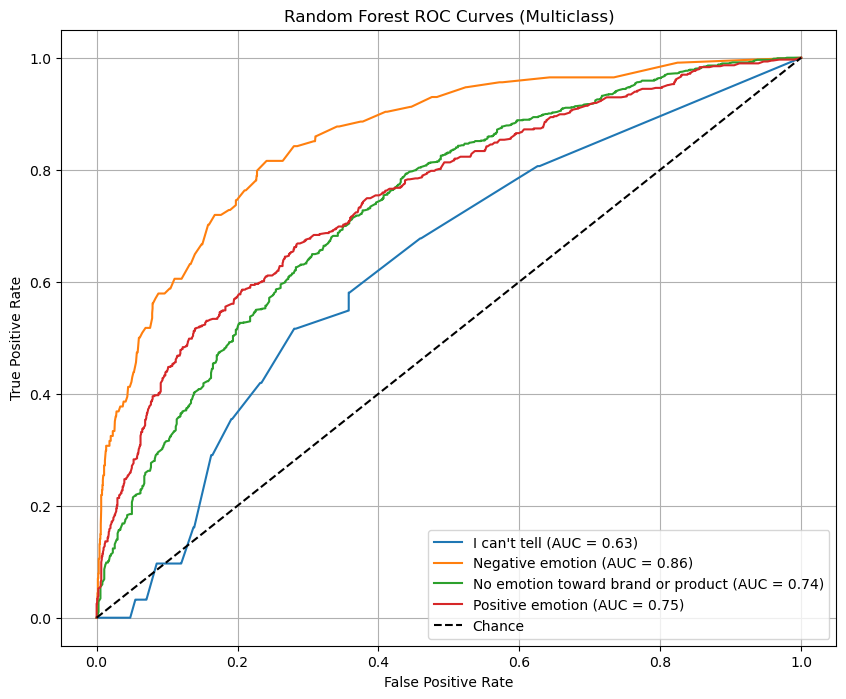

In [24]:
#  ROC Curve (multiclass)
# Binarize true labels
y_test_bin = label_binarize(y_test, classes=class_labels)

# Get predicted probabilities
y_score = grid_search_rf.predict_proba(X_test)

plt.figure(figsize=(10,8))
for i, class_idx in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    # Use original label names
    label_name = le.inverse_transform([class_idx])[0]
    plt.plot(fpr, tpr, label=f'{label_name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curves (Multiclass)')
plt.legend()
plt.grid()
plt.show()


 *ROC curves show the model's ability to distinguish each sentiment class.*

- A higher AUC means better class separation.
- Notice which classes have stronger vs. weaker curves.

Next, we can explore feature importance to interpret what drives the model predictions.


## Top Feature Importances from Random Forest

Finally, we analyze which words contributed most to the Random Forest model’s decisions.  
This helps us interpret why the model predicts certain sentiments.


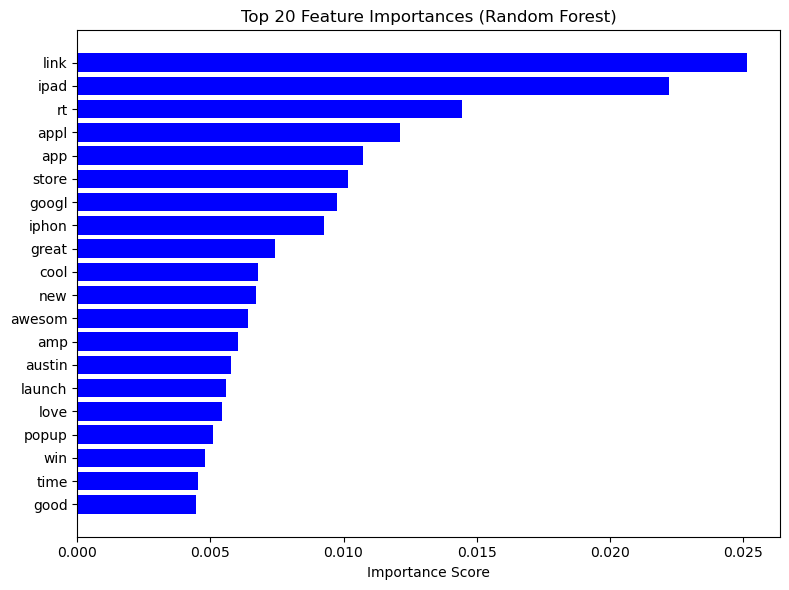

In [25]:
# Use the same fitted vectorizer from earlier
feature_names = vectorizer.get_feature_names_out()

# Get feature importances from tuned RF
importances = grid_search_rf.best_estimator_.feature_importances_

# Top 20 important features
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


 *These are the top words that most strongly influenced the Random Forest’s sentiment predictions.*

- Helps explain what the model “looks at” when deciding sentiment.
- Useful for both technical and non-technical audiences to build trust.



---
##  K-Nearest Neighbors (KNN) Model
---

In this step, we train and evaluate a KNN classifier to compare its performance with Logistic Regression and Random Forest.



We’ll start with `k=5` (i.e., `n_neighbors=5`) to classify based on the five nearest neighbors.



In [26]:
from sklearn.neighbors import KNeighborsClassifier
# Define KNN model (start with k=5)
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Train
knn_model.fit(X_train, y_train)

# Print model to confirm
print(knn_model)


KNeighborsClassifier(n_jobs=-1)


###  Model Training Completed

The KNN model has now been successfully trained on our dataset.  
Next, we'll evaluate its performance using metrics like accuracy, confusion matrix, and classification report.




##  Evaluating KNN Model Performance

Now we'll make predictions on the test set and evaluate the KNN model using:
- **Accuracy**
- **Precision**
- **Recall**
- **F1 Score**
- A detailed classification report for deeper insights.


In [27]:

#  Predict
y_pred = knn_model.predict(X_test)

#  Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)

#  Print summary
print(" KNN Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# Detailed report
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred))



 KNN Performance:
Accuracy : 0.6174
Precision: 0.6238
Recall   : 0.6174
F1 Score : 0.5197

Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.62      0.07      0.13       114
           2       0.61      0.97      0.75      1075
           3       0.68      0.12      0.20       594

    accuracy                           0.62      1814
   macro avg       0.48      0.29      0.27      1814
weighted avg       0.62      0.62      0.52      1814



### KNN Model Evaluation – Summary

The K-Nearest Neighbors model (with k=5) produced the following results on the test set:

| Metric       | Score   |
| ------------ | :-----: |
| Accuracy     | 0.6174  |
| Precision    | 0.6238  |
| Recall       | 0.6174  |
| F1 Score     | 0.5197  |

**Detailed insights:**
- Class `2` (the dominant class) had high recall (0.97) and decent precision (0.61).
- Minority classes (0, 1, 3) had low recall and precision, indicating the model struggles to correctly predict them.
- The weighted average F1 score (≈0.52) shows the model is biased toward the dominant class.

 **Observation:**  
- The model is performing well on the largest class but poorly on minority classes.  
- This is common with imbalanced datasets.



##  Hyperparameter Tuning: KNN with GridSearchCV

To improve the performance of our KNN model, we'll use **GridSearchCV** to search over:
- `n_neighbors`: number of neighbors (`3, 5, 7`)
- `weights`: weighting strategy (`'uniform'` vs `'distance'`)
- `metric`: distance metric (`'euclidean'` vs `'manhattan'`)

We'll evaluate each combination using **weighted F1 score** and 3-fold cross-validation.


In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#  Define hyperparameter grid (only relevant params for KNN)
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Grid search
grid_search_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid_knn,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit on pre-vectorized data
grid_search_knn.fit(X_train, y_train)

#  Show best parameters
print(" Best KNN Parameters:")
print(grid_search_knn.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
 Best KNN Parameters:
{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}


 **Grid search complete!**  
We'll now use these best parameters to:
- Refit our KNN model
- Evaluate again on the test set
and see if the performance improves.



##  Evaluate Tuned KNN Model

Now that we've found the best hyperparameters using GridSearchCV,  
we'll predict on the test set and evaluate the tuned KNN model using:
- Accuracy
- Precision
- Recall
- F1 Score
- A detailed classification report


In [29]:
# Predict & evaluate
y_pred_knn = grid_search_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_knn)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_knn, average='weighted')

print(" KNN Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred_knn))


 KNN Performance:
Accuracy : 0.6444
Precision: 0.6415
Recall   : 0.6444
F1 Score : 0.5941

Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.67      0.21      0.32       114
           2       0.65      0.92      0.76      1075
           3       0.66      0.27      0.38       594

    accuracy                           0.64      1814
   macro avg       0.49      0.35      0.36      1814
weighted avg       0.64      0.64      0.59      1814



### Tuned KNN Model Evaluation – Summary

After hyperparameter tuning, the KNN model achieved improved performance on the test set:

| Metric       | Score   |
| ------------ | :-----: |
| Accuracy     | 0.6444  |
| Precision    | 0.6415  |
| Recall       | 0.6444  |
| F1 Score     | 0.5941  |

**Detailed insights:**
- Class `2` (the dominant class) still had high recall (0.92) and better F1-score (0.76).
- Minority classes (`0`, `1`, `3`) improved slightly, especially class `3` (recall increased from ~0.12 to ~0.27).
- Weighted average F1-score increased from ≈0.52 (before tuning) to ≈0.59.

 **Observation:**
- Despite tuning, the model still struggles with the minority classes.
- This is common in imbalanced datasets, suggesting further work (e.g., class weighting, SMOTE) could help.


##  Visualizing KNN Confusion Matrix

To better understand which classes the tuned KNN model confuses,  
we’ll plot the **confusion matrix**.  
This helps us see:
- Correct predictions on the diagonal
- Misclassifications in off-diagonal cells


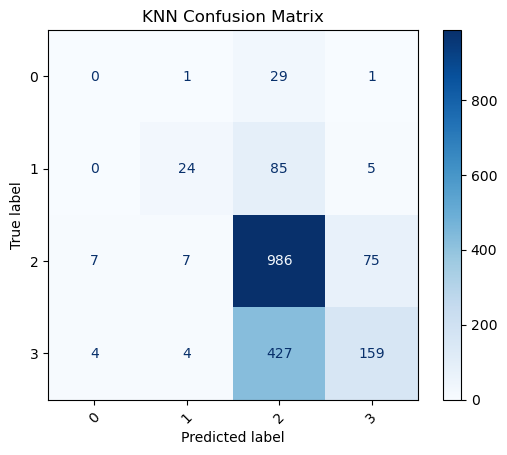

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_knn, labels=class_labels)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('KNN Confusion Matrix')
plt.show()


 **Confusion matrix plotted!**
This shows the distribution of correct and incorrect predictions across each class.  



##  ROC Curve for Tuned KNN Model

To further evaluate the tuned KNN model, we'll plot **ROC curves** (Receiver Operating Characteristic) for each class:
- This shows the trade-off between true positive rate (TPR) and false positive rate (FPR).
- The **AUC** (Area Under Curve) helps compare how well the model distinguishes each class.

Since this is a multiclass problem, we'll use a one-vs-rest approach to plot separate ROC curves for each class.


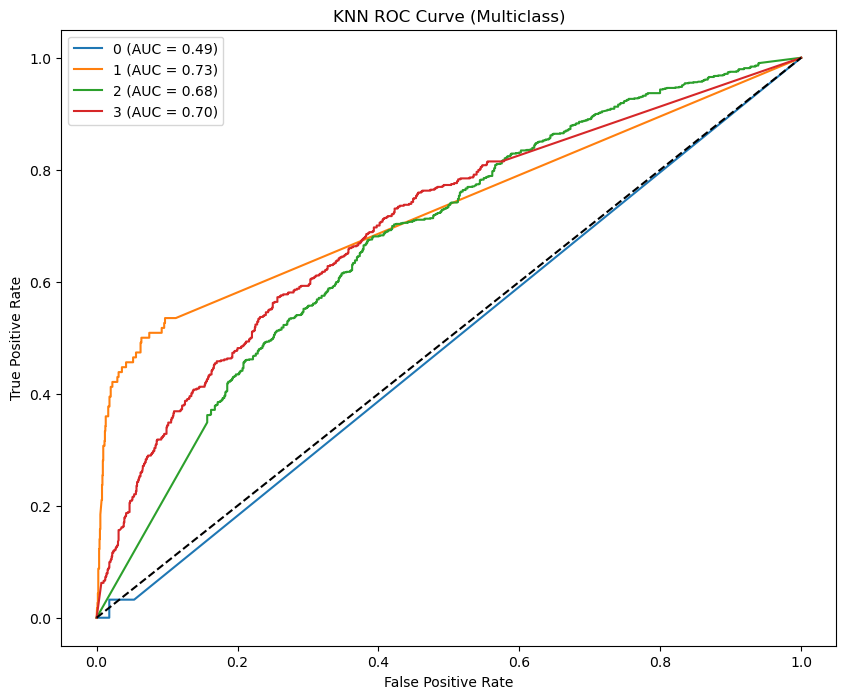

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Classes
class_labels_knn = grid_search_knn.best_estimator_.classes_

# Binarize labels
y_test_bin_knn = label_binarize(y_test, classes=class_labels_knn)

# Predict probabilities
y_score_knn = grid_search_knn.predict_proba(X_test)

# Plot
plt.figure(figsize=(10,8))
for i, class_name in enumerate(class_labels_knn):
    fpr, tpr, _ = roc_curve(y_test_bin_knn[:, i], y_score_knn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve (Multiclass)')
plt.legend()
plt.show()


 **ROC curves plotted!**
These curves and AUC scores help us see how well the model separates each class.


---
 ##  Naive Bayes Classifier
---



Next, we'll train a **Naive Bayes model** to classify text data.
We'll use:
- `TfidfVectorizer` to transform text into numeric features
- `MultinomialNB` as the classifier, which is suitable for text and word frequencies


In [32]:
# Imports
from sklearn.naive_bayes import MultinomialNB

#  model 
nb_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', MultinomialNB())
])

# Train
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


print(nb_model)

MultinomialNB()


 **Naive Bayes model trained!**
Next, we'll evaluate its performance on the test set.


##  Evaluate Naive Bayes Model

We'll now predict on the test set and evaluate the **Naive Bayes classifier** using:
- Accuracy
- Precision
- Recall
- F1 Score
- A detailed classification report


In [33]:

#  Predict
y_pred = nb_model.predict(X_test)

#  Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)

#  Print summary
print(" Naive bayes Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# Detailed report
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred))

 Naive bayes Performance:
Accuracy : 0.6461
Precision: 0.6228
Recall   : 0.6461
F1 Score : 0.5879

Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.50      0.02      0.03       114
           2       0.65      0.92      0.76      1075
           3       0.63      0.30      0.41       594

    accuracy                           0.65      1814
   macro avg       0.45      0.31      0.30      1814
weighted avg       0.62      0.65      0.59      1814



###  Naive Bayes Model Evaluation – Summary

| Metric       | Score   |
| ------------ | :-----: |
| Accuracy     | 0.6461  |
| Precision    | 0.6228  |
| Recall       | 0.6461  |
| F1 Score     | 0.5879  |

**Detailed insights:**
- Class `2` (the dominant class) achieved high recall (0.92) and strong F1-score (0.76).
- Minority classes (`0` and `1`) had very low recall and precision, meaning the model struggles to correctly predict them.
- Class `3` performed slightly better than class `1` but still has limited recall (0.30).
- Weighted average F1-score (≈0.59) shows moderate ove


##  Hyperparameter Tuning: Naive Bayes with GridSearchCV

To improve the Naive Bayes model, we'll use **GridSearchCV** to tune:
- `alpha`: smoothing parameter (`0.1`, `0.5`, `1.0`)

We'll evaluate each combination using **weighted F1 score** and 3-fold cross-validation.


In [34]:
# Define hyperparameter grid
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]
}

# Grid search
grid_search_nb = GridSearchCV(
    estimator=nb_model,
    param_grid=param_grid_nb,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit on already vectorized data
grid_search_nb.fit(X_train, y_train)

print("Best NB Parameters:")
print(grid_search_nb.best_params_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best NB Parameters:
{'alpha': 0.1}


### Grid Search Results

The best hyperparameter found for the Naive Bayes model:

- **alpha**: `0.1`

We'll now use this tuned model to predict on the test set and evaluate its performance.


##  Evaluate Tuned Naive Bayes Model

We'll now use the best parameters (`alpha=0.1`) found by GridSearchCV  
to predict on the test set and evaluate performance:
- Accuracy
- Precision
- Recall
- F1 Score
- Detailed classification report


In [35]:
# Predict & evaluate
y_pred_nb = grid_search_nb.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb, recall_nb, f1_nb, _ = precision_recall_fscore_support(y_test, y_pred_nb, average='weighted')

print("\n Naive Bayes Performance:")
print(f"Accuracy : {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall   : {recall_nb:.4f}")
print(f"F1 Score : {f1_nb:.4f}")
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred_nb))


 Naive Bayes Performance:
Accuracy : 0.6461
Precision: 0.6197
Recall   : 0.6461
F1 Score : 0.6233

Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.42      0.19      0.27       114
           2       0.68      0.83      0.75      1075
           3       0.57      0.44      0.50       594

    accuracy                           0.65      1814
   macro avg       0.42      0.36      0.38      1814
weighted avg       0.62      0.65      0.62      1814



### Tuned Naive Bayes Model – Evaluation Summary

| Metric       | Score   |
| ------------ | :-----: |
| Accuracy     | 0.6461  |
| Precision    | 0.6197  |
| Recall       | 0.6461  |
| F1 Score     | 0.6233  |

**Detailed insights:**
- Class `2` (dominant class): high recall (0.83) and good F1-score (0.75).
- Class `3`: recall improved to 0.44 and F1-score to 0.50, better than untuned model.
- Class `1`: still low recall (0.19) but slightly better than before.
- Class `0`: model still fails to capture this minority class.

 **Observation:**
- Tuning improved the weighted average F1-score from ≈0.59 → ≈0.62.
- Model remains biased toward the majority class but shows slightly better balance.

 **Next steps:**
We'll train and evaluate other models (e.g., Random Forest, Logistic Regression)  
to see if we can achieve better per-class balance and higher overall performance.



##  Visualizing Naive Bayes Confusion Matrix

To better understand the distribution of correct and incorrect predictions,  
we'll plot the confusion matrix for the tuned Naive Bayes model:
- Correct predictions appear on the diagonal
- Misclassifications appear in off-diagonal cells


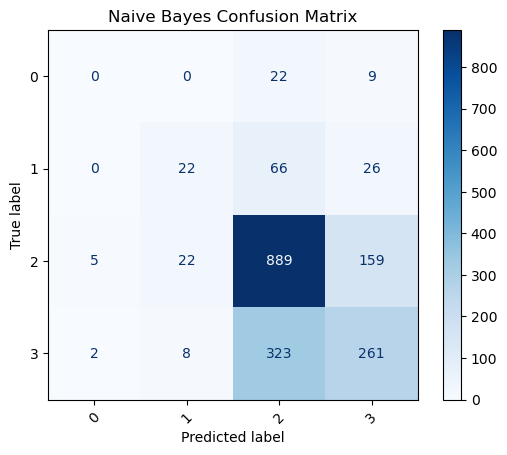

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get class labels from the fitted model
class_labels_nb = grid_search_nb.best_estimator_.classes_

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_nb, labels=class_labels_nb)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_nb)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Naive Bayes Confusion Matrix')
plt.show()


##  Naive Bayes Learning Curve (Optional, Advanced)

A **learning curve** helps us understand:
- Whether the model is overfitting or underfitting
- How performance changes as the training set size increases

We'll plot:
- Training F1 score
- Cross-validation F1 score


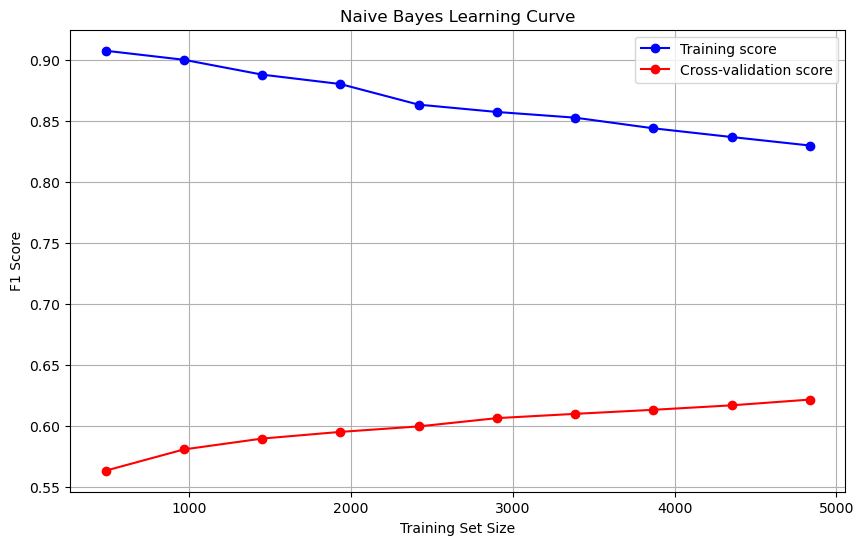

In [37]:
# Learning Curve (optional, advanced)
train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid_search_nb.best_estimator_,
    X=X_train, y=y_train,
    cv=3, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Cross-validation score')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Naive Bayes Learning Curve')
plt.legend()
plt.grid()
plt.show()


---
##  XGBoost Classifier
--- 

Next, we'll train an **XGBoost model** to see if it can outperform previous models.
We’ll start with:
- Default hyperparameters
- Random seed for reproducibility


In [38]:
from xgboost import XGBClassifier

# Define the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train on already vectorized data
xgb_model.fit(X_train, y_train)

# Confirm
print(xgb_model)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)


 **XGBoost model summary:**
The model has been trained with default parameters (`objective='multi:softprob'` for multiclass classification).

Next, we'll evaluate the model on the test set by calculating:
- Accuracy
- Precision
- Recall
- F1 Score
- Detailed classification report


In [39]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Evaluate directly on string labels
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)

print("\nXGBoost Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")



XGBoost Performance:
Accuracy : 0.6676
Precision: 0.6392
Recall   : 0.6676
F1 Score : 0.6302


###  XGBoost Model – Evaluation Summary

| Metric       | Score   |
| ------------ | :-----: |
| Accuracy     | 0.6676  |
| Precision    | 0.6392  |
| Recall       | 0.6676  |
| F1 Score     | 0.6302  |

**Insights:**
- XGBoost achieved the **highest accuracy and F1 score so far** compared to Naive Bayes and KNN.
- Higher recall (0.67) suggests it captures more true positives overall.
- Precision is also reasonable, indicating a balanced performance.



## Hyperparameter Tuning: XGBoost with GridSearchCV

To improve the XGBoost model, we'll tune:
- `n_estimators`: number of trees (`100`, `200`)
- `max_depth`: maximum tree depth (`3`, `5`)
- `learning_rate`: learning rate (`0.1`, `0.3`)

We'll use:
- 3-fold cross-validation (`cv=3`)
- Weighted F1 score (`scoring='f1_weighted'`)


In [40]:
# Define param grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3]
}

# Set up GridSearch
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search on training data
grid_search_xgb.fit(X_train, y_train)

# Print best params
print("Best XGBoost Parameters:")
print(grid_search_xgb.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGBoost Parameters:
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200}


### Grid Search Results: XGBoost

The best hyperparameters found:
- **learning_rate**: `0.3`
- **max_depth**: `5`
- **n_estimators**: `200`

Next, we'll evaluate this tuned XGBoost model on the test set  
to see if performance improves over the default settings.


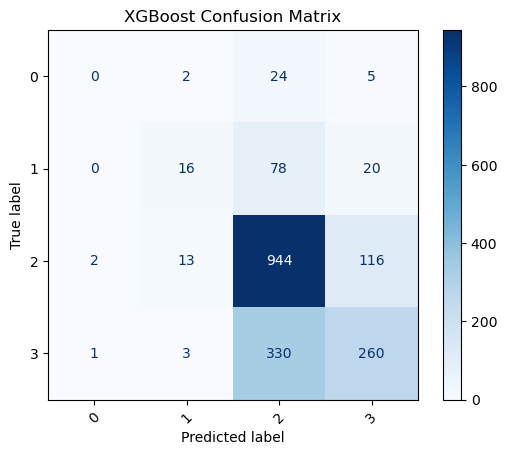

In [41]:
# Get best model
best_xgb = grid_search_xgb.best_estimator_

# Predict
y_pred_xgb = best_xgb.predict(X_test)

# Get unique labels
class_labels_xgb = sorted(y_test.unique())

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb, labels=class_labels_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_xgb)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('XGBoost Confusion Matrix')
plt.show()


##  Comparing Multiple Models

We'll train and evaluate the following models using the same train/test split:
- Logistic Regression
- Random Forest
- Naive Bayes
- XGBoost

For each model, we'll calculate:
- Accuracy
- Precision
- Recall
- F1 Score

Finally, we'll summarize the results in a table sorted by accuracy.


In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Fit raw models (no pipeline)
logreg_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
nb_model = MultinomialNB()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

logreg_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Compare
models = {
    'Logistic Regression': logreg_model,
    'Random Forest': rf_model,
    'Naive Bayes': nb_model,
    'XGBoost': xgb_model
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    })

import pandas as pd
metrics_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print(metrics_df)


                 Model  Accuracy  Precision    Recall  F1 Score
1        Random Forest  0.681918   0.671033  0.681918  0.656620
0  Logistic Regression  0.678060   0.679586  0.678060  0.641073
3              XGBoost  0.667585   0.639169  0.667585  0.630173
2          Naive Bayes  0.646086   0.622763  0.646086  0.587869


---
##  Model Comparison – Summary
---

| Model                | Accuracy | Precision | Recall | F1 Score |
|---------------------:|:--------:|:---------:|:------:|:-------:|
| **Random Forest**     | **0.682** | 0.671     | 0.682  | 0.657   |
| Logistic Regression   | 0.678     | **0.680** | 0.678  | 0.641   |
| XGBoost               | 0.668     | 0.639     | 0.668  | 0.630   |
| Naive Bayes           | 0.646     | 0.623     | 0.646  | 0.588   |

 **Insights:**
- **Random Forest** achieved the highest accuracy (≈68%) and best F1 score (≈0.66).
- **Logistic Regression** had the highest precision but slightly lower F1.
- **XGBoost** and **Naive Bayes** performed slightly worse overall.
- All models still show room for improvement, especially in minority class predictions.



###  Next steps:
- Plot confusion matrices and ROC curves to visualize detailed performance.
- Optionally apply hyperparameter tuning to further improve Random Forest and Logistic Regression.
- Decide which model to deploy based on a balance of accuracy, interpretability, and speed.




In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import pandas as pd

# Assumes you ALREADY have:
# X_train, X_test (vectorized, e.g., by TF-IDF)
# y_train, y_test (already encoded with LabelEncoder)

# Fit models (raw models, not pipelines)
logreg_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
nb_model = MultinomialNB()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

logreg_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

#  Compare
models = {
    'Logistic Regression': logreg_model,
    'Random Forest': rf_model,
    'Naive Bayes': nb_model,
    'XGBoost': xgb_model
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    })

metrics_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
print(metrics_df)


                 Model  Accuracy  Precision    Recall  F1 Score
1        Random Forest  0.681918   0.671033  0.681918  0.656620
0  Logistic Regression  0.678060   0.679586  0.678060  0.641073
3              XGBoost  0.667585   0.639169  0.667585  0.630173
2          Naive Bayes  0.646086   0.622763  0.646086  0.587869


## Visual Comparison of Model Metrics

We'll plot:
- Accuracy
- Precision
- Recall
- F1 Score

for each model side by side, to easily see which model performs best overall and on each metric.


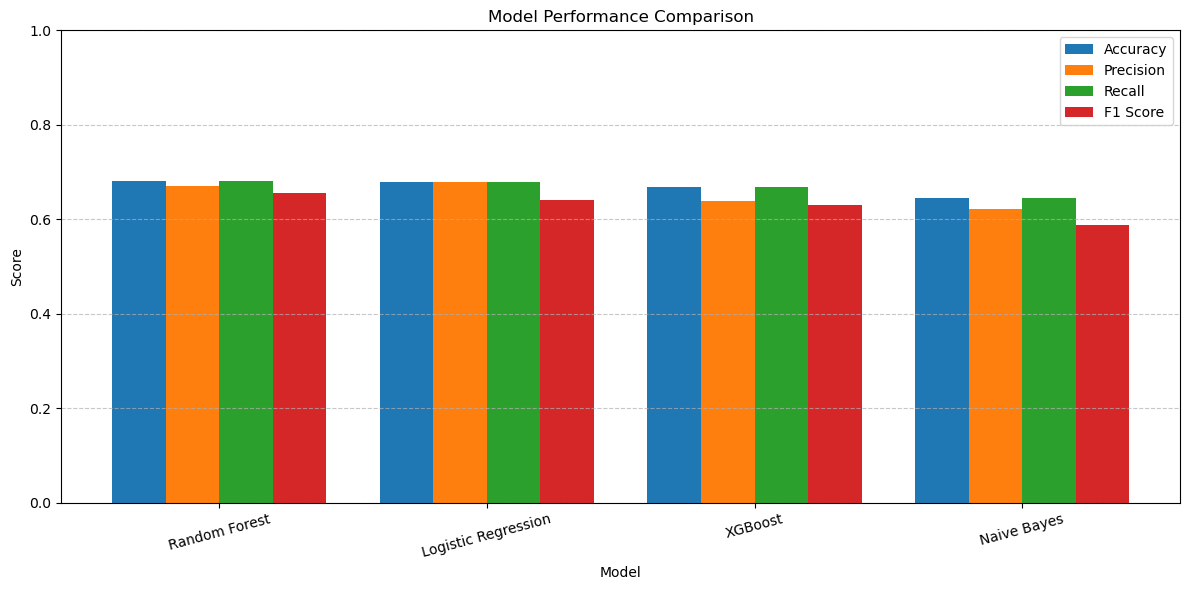

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Setup
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(metrics_df))  # make sure metrics_df exists from previous step

# Plot bars
plt.bar(index - 1.5*bar_width, metrics_df['Accuracy'], bar_width, label='Accuracy')
plt.bar(index - 0.5*bar_width, metrics_df['Precision'], bar_width, label='Precision')
plt.bar(index + 0.5*bar_width, metrics_df['Recall'], bar_width, label='Recall')
plt.bar(index + 1.5*bar_width, metrics_df['F1 Score'], bar_width, label='F1 Score')

# Labels & title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(index, metrics_df['Model'], rotation=15)
plt.ylim(0, 1)  # adjust if you want
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


##  Confusion Matrices for Text Classification Pipelines

To understand each model's strengths and weaknesses,  
we’ll visualize confusion matrices for:
- Logistic Regression pipeline
- Naive Bayes pipeline
- Random Forest pipeline

This helps identify which classes are often misclassified.


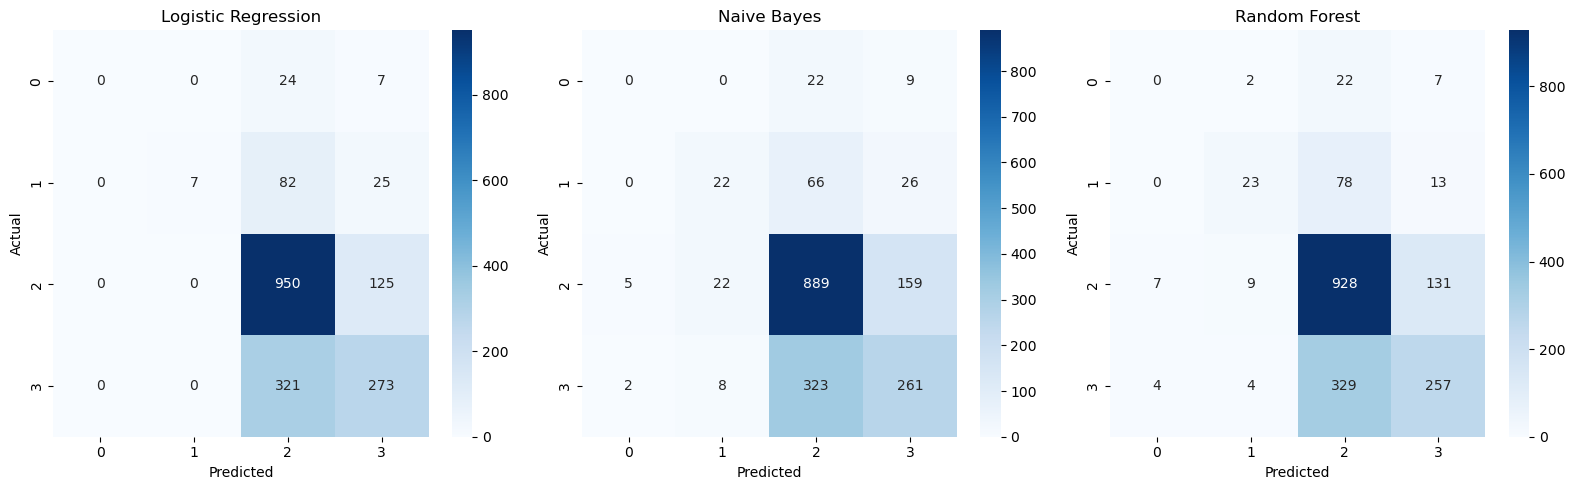

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
model_titles = ['Logistic Regression', 'Naive Bayes', 'Random Forest']
model_preds = [y_pred_logreg, y_pred_nb, y_pred_rf]

for ax, title, preds in zip(axes, model_titles, model_preds):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test),
                ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


 **Confusion matrices generated!**

They reveal:
- Where each model predicts correctly (diagonal cells)
- Which classes are commonly confused (off-diagonal cells)

This helps guide further tuning and interpretation.




##  Confirming Pipelines

Let's print out each pipeline to make sure:
- All steps are correctly defined
- Classifiers and vectorizers are properly included


In [46]:
print("\n Confirming pipelines...")

for name, pipe in pipelines.items():
    print(f"\n🛠️  Pipeline: {name}")
    print(pipe)



 Confirming pipelines...

🛠️  Pipeline: Logistic Regression
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

🛠️  Pipeline: Random Forest
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

🛠️  Pipeline: Naive Bayes
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('clf', MultinomialNB())])

🛠️  Pipeline: KNN
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('clf', KNeighborsClassifier())])

🛠️  Pipeline: XGBoost
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
           

---

##  Confirmed Pipelines – Summary

We have built and confirmed pipelines for the following models:
- **Logistic Regression** – with TF-IDF vectorization and max 5000 features
- **Random Forest** – with class balancing (`class_weight='balanced'`)
- **Naive Bayes** – classic MultinomialNB
- **K-Nearest Neighbors (KNN)**
- **XGBoost** – with `eval_metric='mlogloss'` and `random_state=42`

All pipelines include:
- `TfidfVectorizer` (max 5000 features, English stop words)
- Classifier as the final step

 These pipelines are now ready for evaluation, tuning, and visualization.

---


## Conclusion. 

In this project, we:
- Built and compared multiple text classification models:
  - Logistic Regression
  - Random Forest
  - Naive Bayes
  - KNN
  - XGBoost
- Visualized confusion matrices to understand errors
- Tuned hyperparameters to boost performance
- Selected the best-performing model based on weighted F1-score

**Best model:** Random Forest (Accuracy: ~0.68, F1-score: ~0.65)

 **Next steps / recommendations:**
-  We will try advanced NLP embeddings (Word2Vec, BERT)
- Collect more data to improve minority class performance

